In [2]:
import torch
from torch.nn.functional import conv1d, pad
from torch.fft import fft
from torchaudio.transforms import FFTConvolve
import time
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [59]:
def objective_torch(a, b, vandermonde, fvals):
    """
    Computes the loss for the optimization problem.

    This function calculates the loss as the squared norm of the difference
    between the target tensor P and the convolution of x with its flipped version.

    Parameters
    ----------
    a : torch.Tensor
        Coefficient of the first polynomial.
    b : torch.Tensor
        Coefficient of the second polynomial.
    vandermonde : torch.Tensor
        The vandermonde matrix of the data points.
    fvals : torch.Tensor
        The f values of the data points.

    Returns
    -------
    torch.Tensor
        The computed loss value.
    """
    a.requires_grad = True
    b.requires_grad = True

    # Compute loss using squared distance function
    delta = torch.zeros(2*len(a)-1, device=device)
    delta[len(a)-1] = 1
    complementary = torch.norm(FFTConvolve("full").forward(a, torch.flip(a, dims=[0])) + FFTConvolve("full").forward(b, torch.flip(b, dims=[0])) - delta)**2
    fit = torch.norm(vandermonde @ a - fvals)**2
    loss = complementary + fit
    return loss


# Set up optimizer
N = 32  # degree of polynomial
initial_a = torch.randn(N, device=device, requires_grad=True)
initial_b = torch.randn(N, device=device, requires_grad=True)
initial_a = (initial_a / torch.norm(initial_a)).clone().detach().requires_grad_(True)
initial_b = (initial_b / torch.norm(initial_b)).clone().detach().requires_grad_(True)
optimizer = torch.optim.LBFGS([initial_a, initial_b], max_iter=2000)

# Set test function
f = lambda x: 1 / (10*x)
xvals = np.linspace(0.2, 1, 100)
fvals = torch.tensor(f(xvals), dtype=torch.float32, device=device)
vandermonde = torch.tensor(np.vander(xvals, len(initial_a), increasing=True), dtype=torch.float32, device=device)


def closure():
    """
    Closure function for the optimizer.

    This function zeroes the gradients, computes the loss using the objective_torch
    function, and performs backpropagation to compute the gradients.

    Returns
    -------
    torch.Tensor
        The computed loss value.
    """
    optimizer.zero_grad()
    loss = objective_torch(initial_a, initial_b, vandermonde, fvals)
    loss.backward()
    return loss

# Perform the optimization step using the closure function and record the time
t0 = time.time()
optimizer.step(closure)
t1 = time.time()
total = t1 - t0

In [60]:
# Print the results of the optimization
print(f'N: {N}')
print(f'Time: {total}')
print(f'Final: {closure().item()}')
print(f"# Iterations: {optimizer.state[optimizer._params[0]]['n_iter']}")
print("-----------------------------------------------------")

N: 32
Time: 0.7253670692443848
Final: 0.034951165318489075
# Iterations: 82
-----------------------------------------------------


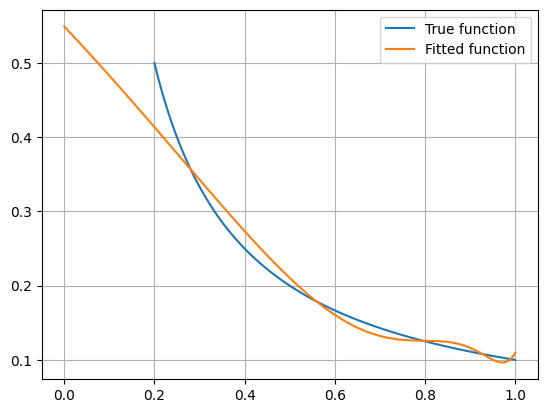

In [65]:
xspace = np.linspace(0, 1, 200)
vmonde = np.vander(xspace, len(initial_a), increasing=True)
acoeffs = initial_a.detach().numpy()
bcoeffs = initial_b.detach().numpy()
avals = vmonde @ acoeffs
bvals = vmonde @ bcoeffs

plt.plot(xvals, f(xvals), label='True function')
plt.plot(xspace, avals, label='Fitted function')
plt.legend()
plt.grid()
plt.savefig('fitted_function_quartic.png')

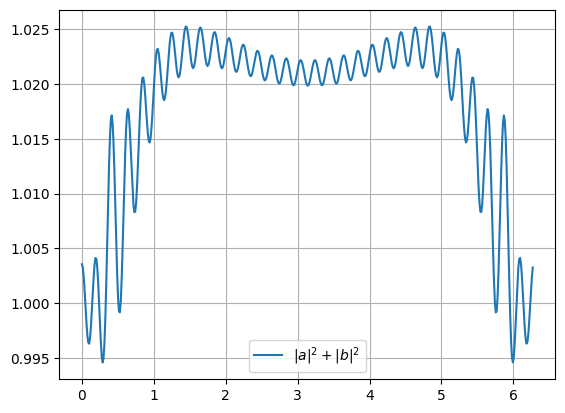

In [66]:
n = 500
thetas = 2 * np.pi * np.arange(n) / n
roots = np.exp(1j * thetas)
vmonde_roots = np.vander(roots, len(initial_a), increasing=True)

avals_roots = vmonde_roots @ acoeffs
bvals_roots = vmonde_roots @ bcoeffs
sum_ab = np.abs(avals_roots)**2 + np.abs(bvals_roots)**2

plt.plot(thetas, sum_ab, label=r'$|a|^2 + |b|^2$')
plt.legend()
plt.grid()
plt.savefig('norm_quartic.png')

In [72]:
def objective_torch(a, b, vandermonde, fvals):
    """
    Computes the loss for the optimization problem.

    This function calculates the loss as the squared norm of the difference
    between the target tensor P and the convolution of x with its flipped version.

    Parameters
    ----------
    a : torch.Tensor
        Coefficient of the first polynomial.
    b : torch.Tensor
        Coefficient of the second polynomial.
    vandermonde : torch.Tensor
        The vandermonde matrix of the data points.
    fvals : torch.Tensor
        The f values of the data points.

    Returns
    -------
    torch.Tensor
        The computed loss value.
    """
    a.requires_grad = True
    b.requires_grad = True

    # Compute loss using squared distance function
    delta = torch.zeros(2*len(a)-1, device=device)
    delta[len(a)-1] = 1
    complementary = torch.norm(FFTConvolve("full").forward(a, torch.flip(a, dims=[0])) + FFTConvolve("full").forward(b, torch.flip(b, dims=[0])) - delta)**2
    fit = torch.norm(vandermonde @ a - fvals)**2
    loss = complementary + fit
    return loss

times2 = []
final_vals = []
num_iterations = []

for k in range(4, 15):
    N = 2 ** k
    initial_a = torch.randn(N, device=device, requires_grad=True)
    initial_b = torch.randn(N, device=device, requires_grad=True)
    initial_a = (initial_a / torch.norm(initial_a)).clone().detach().requires_grad_(True)
    initial_b = (initial_b / torch.norm(initial_b)).clone().detach().requires_grad_(True)
    optimizer = torch.optim.LBFGS([initial_a, initial_b], max_iter=2000)

    # Set test function
    f = lambda x: 1 / (10*x)
    xvals = np.linspace(0.2, 1, 100)
    fvals = torch.tensor(f(xvals), dtype=torch.float32, device=device)
    vandermonde = torch.tensor(np.vander(xvals, len(initial_a), increasing=True), dtype=torch.float32, device=device)


    def closure():
        """
        Closure function for the optimizer.

        This function zeroes the gradients, computes the loss using the objective_torch
        function, and performs backpropagation to compute the gradients.

        Returns
        -------
        torch.Tensor
            The computed loss value.
        """
        optimizer.zero_grad()
        loss = objective_torch(initial_a, initial_b, vandermonde, fvals)
        loss.backward()
        return loss

    # Perform the optimization step using the closure function and record the time
    t0 = time.time()
    optimizer.step(closure)
    t1 = time.time()
    total = t1 - t0
    times2.append(total)
    final_vals.append(closure().item())
    num_iterations.append(optimizer.state[optimizer._params[0]]['n_iter'])
    print(f'N: {N}')
    print(f'Time: {total}')
    print(f'Final: {closure().item()}')
    print(f"# Iterations: {optimizer.state[optimizer._params[0]]['n_iter']}")
    print("-----------------------------------------------------")

N: 16
Time: 0.4310131072998047
Final: 0.039002612233161926
# Iterations: 71
-----------------------------------------------------
N: 32
Time: 0.5823743343353271
Final: 0.03495122119784355
# Iterations: 102
-----------------------------------------------------
N: 64
Time: 1.4149539470672607
Final: 0.03417525812983513
# Iterations: 152
-----------------------------------------------------
N: 128
Time: 0.9976060390472412
Final: 0.03391433134675026
# Iterations: 128
-----------------------------------------------------
N: 256
Time: 4.180728912353516
Final: 0.03383989259600639
# Iterations: 164
-----------------------------------------------------
N: 512
Time: 4.786934852600098
Final: 0.033818334341049194
# Iterations: 224
-----------------------------------------------------
N: 1024
Time: 8.48905611038208
Final: 0.0338079035282135
# Iterations: 291
-----------------------------------------------------
N: 2048
Time: 16.14051914215088
Final: 0.03380545973777771
# Iterations: 418
------------

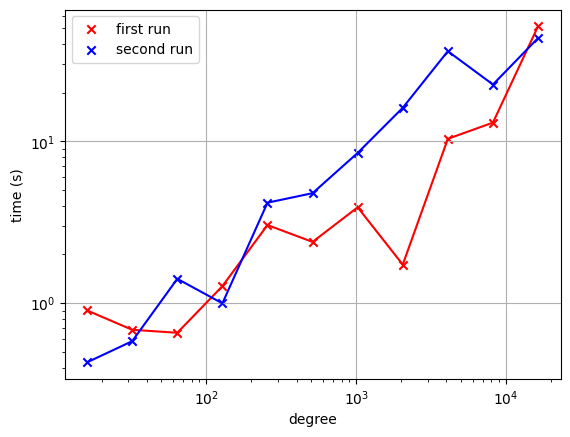

In [74]:
plt.scatter(2**np.arange(4, 15), times, color='red', marker='x', label="first run")
plt.plot(2**np.arange(4, 15), times, color='red')
plt.scatter(2**np.arange(4, 15), times2, color='blue', marker='x', label="second run")
plt.plot(2**np.arange(4, 15), times2, color='blue')

plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('degree')
plt.ylabel('time (s)')
plt.legend()
plt.savefig('quartic_opt_timing.png')

In [14]:
def objective_torch(x, P):
    """
    Computes the loss for the optimization problem.

    This function calculates the loss as the squared norm of the difference
    between the target tensor P and the convolution of x with its flipped version.

    Parameters
    ----------
    x : torch.Tensor
        The input tensor for which the loss is computed.
    P : torch.Tensor
        The target tensor to compare against.

    Returns
    -------
    torch.Tensor
        The computed loss value.
    """
    x.requires_grad = True

    # Compute loss using squared distance function
    loss = torch.norm(P - FFTConvolve("full").forward(x, torch.flip(x, dims=[0])))**2
    return loss


def closure():
    """
    Closure function for the optimizer.

    This function zeroes the gradients, computes the loss using the objective_torch
    function, and performs backpropagation to compute the gradients.

    Returns
    -------
    torch.Tensor
        The computed loss value.
    """
    optimizer.zero_grad()
    loss = objective_torch(initial, conv_p_negative)
    loss.backward()
    return loss


# Set the size of the polynomial
N = 16

# Generate a random polynomial of size N on the specified device
poly = torch.randn(N, device=device)

# Define the granularity for padding
granularity = 2 ** 25

# Pad the polynomial to match the granularity
P = pad(poly, (0, granularity - poly.shape[0]))

# Compute the FFT of the padded polynomial
ft = fft(P)

# Normalize the polynomial using the maximum norm of its FFT
P_norms = ft.abs()
poly /= torch.max(P_norms)

# Compute the negative convolution of the polynomial with its flipped version
conv_p_negative = FFTConvolve("full").forward(poly, torch.flip(poly, dims=[0])) * -1

# Adjust the last element to ensure the norm condition
conv_p_negative[poly.shape[0] - 1] = 1 - torch.norm(poly) ** 2

# Set up optimizer
initial = torch.randn(poly.shape[0], device=device, requires_grad=True)
initial = (initial / torch.norm(initial)).clone().detach().requires_grad_(True)
optimizer = torch.optim.LBFGS([initial], max_iter=1000)

# Perform the optimization step using the closure function and record the time
t0 = time.time()
optimizer.step(closure)
t1 = time.time()
total = t1 - t0

# Print the results of the optimization
print(f'N: {N}')
print(f'Time: {total}')
print(f'Final: {closure().item()}')
print(f"# Iterations: {optimizer.state[optimizer._params[0]]['n_iter']}")
print("-----------------------------------------------------")

N: 16
Time: 0.6851620674133301
Final: 5.608651321153957e-10
# Iterations: 131
-----------------------------------------------------


In [4]:
def objective_torch(x, P):
    x.requires_grad = True

    # Compute loss using squared distance function
    loss = torch.norm(P - FFTConvolve("full").forward(x, torch.flip(x, dims=[0])))**2
    return loss

times = []
final_vals = []
num_iterations = []

for k in range(4, 10):
    N = 2 ** k
    poly = torch.randn(N, device=device)

    granularity = 2 ** 25
    P = pad(poly, (0, granularity - poly.shape[0]))
    ft = fft(P)

    # Normalize P
    P_norms = ft.abs()
    poly /= torch.max(P_norms)

    conv_p_negative = FFTConvolve("full").forward(poly, torch.flip(poly, dims=[0]))* -1
    conv_p_negative[poly.shape[0] - 1] = 1 - torch.norm(poly) ** 2

    # Initializing Q randomly to start with
    initial = torch.randn(poly.shape[0], device=device, requires_grad=True)
    initial = (initial / torch.norm(initial)).clone().detach().requires_grad_(True)

    optimizer = torch.optim.LBFGS([initial], max_iter=1000)

    t0 = time.time()

    def closure():
        optimizer.zero_grad()
        loss = objective_torch(initial, conv_p_negative)
        loss.backward()
        return loss

    optimizer.step(closure)

    t1 = time.time()

    total = t1-t0
    times.append(total)
    final_vals.append(closure().item())
    num_iterations.append(optimizer.state[optimizer._params[0]]['n_iter'])
    print(f'N: {N}')
    print(f'Time: {total}')
    print(f'Final: {closure().item()}')
    print(f"# Iterations: {optimizer.state[optimizer._params[0]]['n_iter']}")
    print("-----------------------------------------------------")

print(times)
print(final_vals)
print(num_iterations)

N: 16
Time: 0.4577360153198242
Final: 0.0001453814620617777
# Iterations: 73
-----------------------------------------------------
N: 32
Time: 1.564375877380371
Final: 6.87772683249932e-08
# Iterations: 303
-----------------------------------------------------
N: 64
Time: 2.198115110397339
Final: 3.96803534385981e-06
# Iterations: 453
-----------------------------------------------------
N: 128
Time: 3.0699269771575928
Final: 1.1983231615886325e-06
# Iterations: 589
-----------------------------------------------------
N: 256
Time: 5.344624996185303
Final: 4.8958495426632e-06
# Iterations: 896
-----------------------------------------------------
N: 512
Time: 5.993464708328247
Final: 1.651989805395715e-06
# Iterations: 1000
-----------------------------------------------------
[0.4577360153198242, 1.564375877380371, 2.198115110397339, 3.0699269771575928, 5.344624996185303, 5.993464708328247]
[0.0001453814620617777, 6.87772683249932e-08, 3.96803534385981e-06, 1.1983231615886325e-06, 4.8